In [2]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [3]:

%cd /gdrive/MyDrive/ANNDL/Challange_2

/gdrive/MyDrive/ANNDL/Challange_2


In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

In [6]:
seed = 42

np.random.seed(seed)

import logging

import random
random.seed(seed)

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [8]:
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18300324167620413926
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14410383360
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6671217296274245988
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [10]:
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.14.0


In [12]:
categories = np.load('/content/categories.npy')
categories.shape
categories

array(['D', 'D', 'D', ..., 'F', 'F', 'F'], dtype='<U1')

In [15]:
valid_periods = np.load('/content/valid_periods.npy')
valid_periods.shape
valid_periods

array([[2325, 2776],
       [2325, 2776],
       [2325, 2776],
       ...,
       [2676, 2776],
       [2676, 2776],
       [2676, 2776]])

In [13]:
training_data = np.load('/gdrive/MyDrive/training_data.npy')
training_data


array([[0.        , 0.        , 0.        , ..., 0.60277778, 0.36759259,
        0.33148148],
       [0.        , 0.        , 0.        , ..., 0.6       , 0.46      ,
        0.396     ],
       [0.        , 0.        , 0.        , ..., 0.96048126, 0.94650625,
        0.97714021],
       ...,
       [0.        , 0.        , 0.        , ..., 0.52631579, 0.58223684,
        0.55263158],
       [0.        , 0.        , 0.        , ..., 0.44559585, 0.58549223,
        0.40414508],
       [0.        , 0.        , 0.        , ..., 0.54268293, 0.6097561 ,
        0.59146341]])

In [16]:
training_data_df = pd.DataFrame(training_data)
training_data_df.info()
training_data_df = training_data_df.astype(np.float32)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float64(2776)
memory usage: 1016.6 MB


In [17]:
min, max = (9999, -1), (0, -1)
for i, tuple in enumerate(valid_periods):
    diff = tuple[1] - tuple[0]
    if diff < min[0]: min = (diff, i)
    if diff > max[0]: max = (diff, i)

min, max
index_shortest = min[1]
index_longest = max[1]

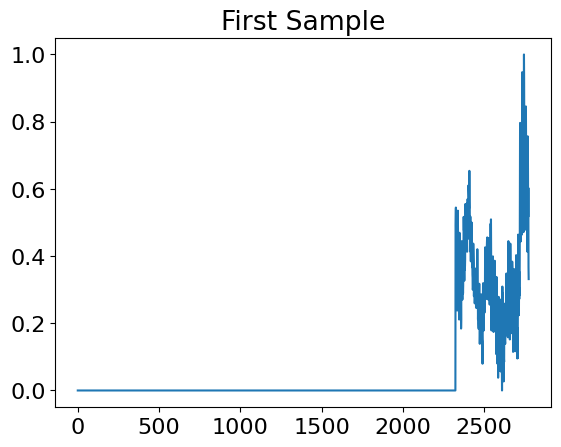

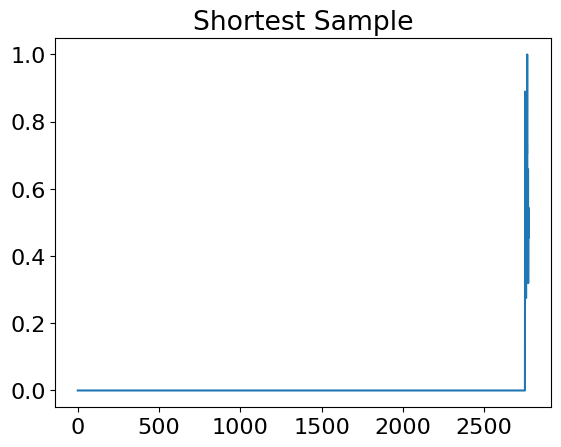

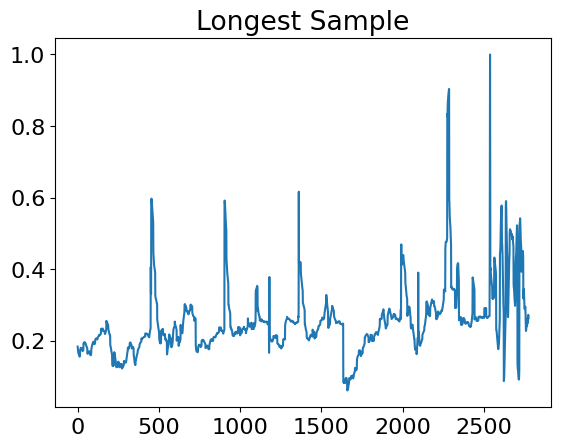

In [18]:
sample_first = training_data_df.T[0]
sample_shortest = training_data_df.T[index_shortest]
sample_longest = training_data_df.T[index_longest]
import matplotlib.pyplot as plt

plt.plot(sample_first)
plt.title('First Sample')
plt.show()

plt.plot(sample_shortest)
plt.title('Shortest Sample')
plt.show()

plt.plot(sample_longest)
plt.title('Longest Sample')
plt.show()

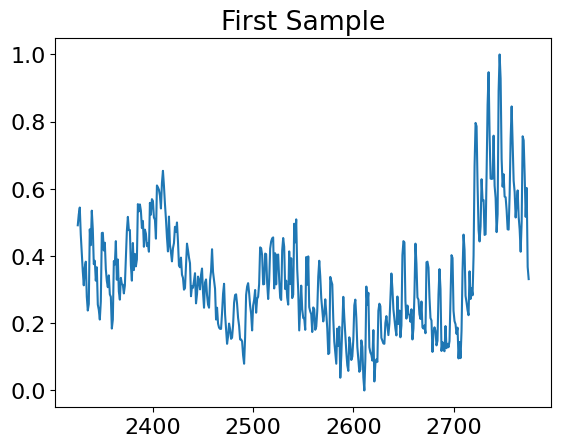

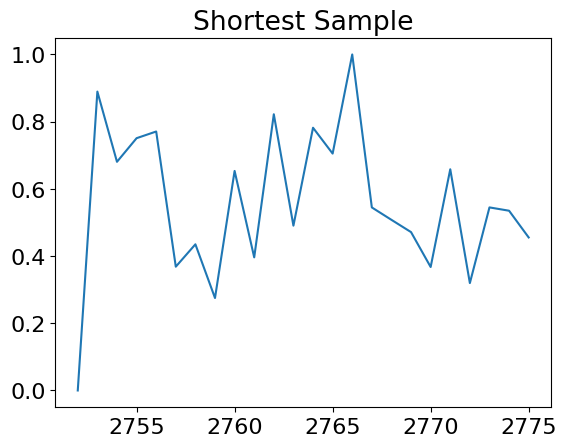

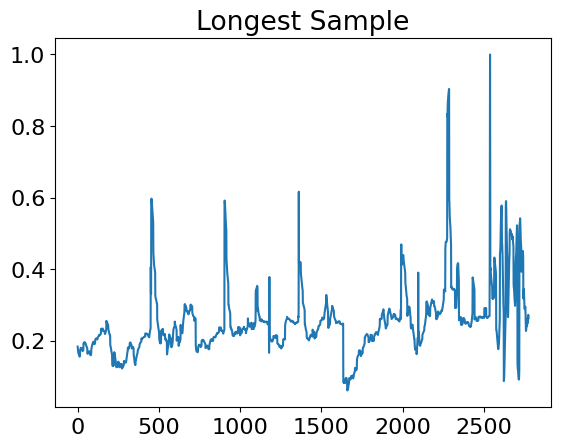

In [19]:
start_first, end_first = valid_periods[0]
sample_first_trimmed = sample_first[start_first:end_first]

plt.plot(sample_first_trimmed)
plt.title('First Sample')
plt.show()



start_shortest, end_shortest = valid_periods[index_shortest]
sample_shortest_trimmed = sample_shortest[start_shortest:end_shortest]

plt.plot(sample_shortest_trimmed)
plt.title('Shortest Sample')
plt.show()



start_longest, end_longest = valid_periods[index_longest]
sample_longest_trimmed = sample_longest[start_longest:end_longest]

plt.plot(sample_longest_trimmed)
plt.title('Longest Sample')
plt.show()

In [20]:
category_counts = np.unique(categories, return_counts=True)
for category, count in zip(category_counts[0], category_counts[1]):
    print(f"Category {category}: {count}")


Category A: 5728
Category B: 10987
Category C: 10017
Category D: 10016
Category E: 10975
Category F: 277


In [21]:
lengths = valid_periods[:, 1] - valid_periods[:, 0]
lengths.shape

(48000,)

In [23]:
intervals = [(0, 300), (301, 600), (601, 900), (901, 1200), (1201, 1500),
             (1501, 1800), (1801, 2100), (2101, 2400), (2401, 2776)]

In [24]:

interval_counts = {}
for category in categories:
    interval_counts[category] = {}
    for interval in intervals:
        interval_counts[category][interval] = 0

interval_counts



{'D': {(0, 300): 0,
  (301, 600): 0,
  (601, 900): 0,
  (901, 1200): 0,
  (1201, 1500): 0,
  (1501, 1800): 0,
  (1801, 2100): 0,
  (2101, 2400): 0,
  (2401, 2776): 0},
 'E': {(0, 300): 0,
  (301, 600): 0,
  (601, 900): 0,
  (901, 1200): 0,
  (1201, 1500): 0,
  (1501, 1800): 0,
  (1801, 2100): 0,
  (2101, 2400): 0,
  (2401, 2776): 0},
 'A': {(0, 300): 0,
  (301, 600): 0,
  (601, 900): 0,
  (901, 1200): 0,
  (1201, 1500): 0,
  (1501, 1800): 0,
  (1801, 2100): 0,
  (2101, 2400): 0,
  (2401, 2776): 0},
 'C': {(0, 300): 0,
  (301, 600): 0,
  (601, 900): 0,
  (901, 1200): 0,
  (1201, 1500): 0,
  (1501, 1800): 0,
  (1801, 2100): 0,
  (2101, 2400): 0,
  (2401, 2776): 0},
 'B': {(0, 300): 0,
  (301, 600): 0,
  (601, 900): 0,
  (901, 1200): 0,
  (1201, 1500): 0,
  (1501, 1800): 0,
  (1801, 2100): 0,
  (2101, 2400): 0,
  (2401, 2776): 0},
 'F': {(0, 300): 0,
  (301, 600): 0,
  (601, 900): 0,
  (901, 1200): 0,
  (1201, 1500): 0,
  (1501, 1800): 0,
  (1801, 2100): 0,
  (2101, 2400): 0,
  (2401, 277

In [25]:

for category, length in zip(categories, lengths):
    for interval in intervals:
        if interval[0] <= length < interval[1]:
            interval_counts[category][interval] += 1
            break

interval_counts_df = pd.DataFrame(interval_counts)

interval_ranges = [f"{start}-{end}" for start, end in intervals]
interval_counts_df.index = interval_ranges

interval_counts_df


,D,E,A,C,B,F
0-300,7712,10320,4276,8527,10145,230
301-600,2094,571,1368,1235,722,40
601-900,115,30,71,143,67,6
901-1200,5,5,1,17,3,1
1201-1500,2,3,0,3,3,0
1501-1800,0,0,0,2,0,0
1801-2100,3,0,1,0,0,0
2101-2400,0,1,0,1,0,0
2401-2776,1,0,0,2,0,0


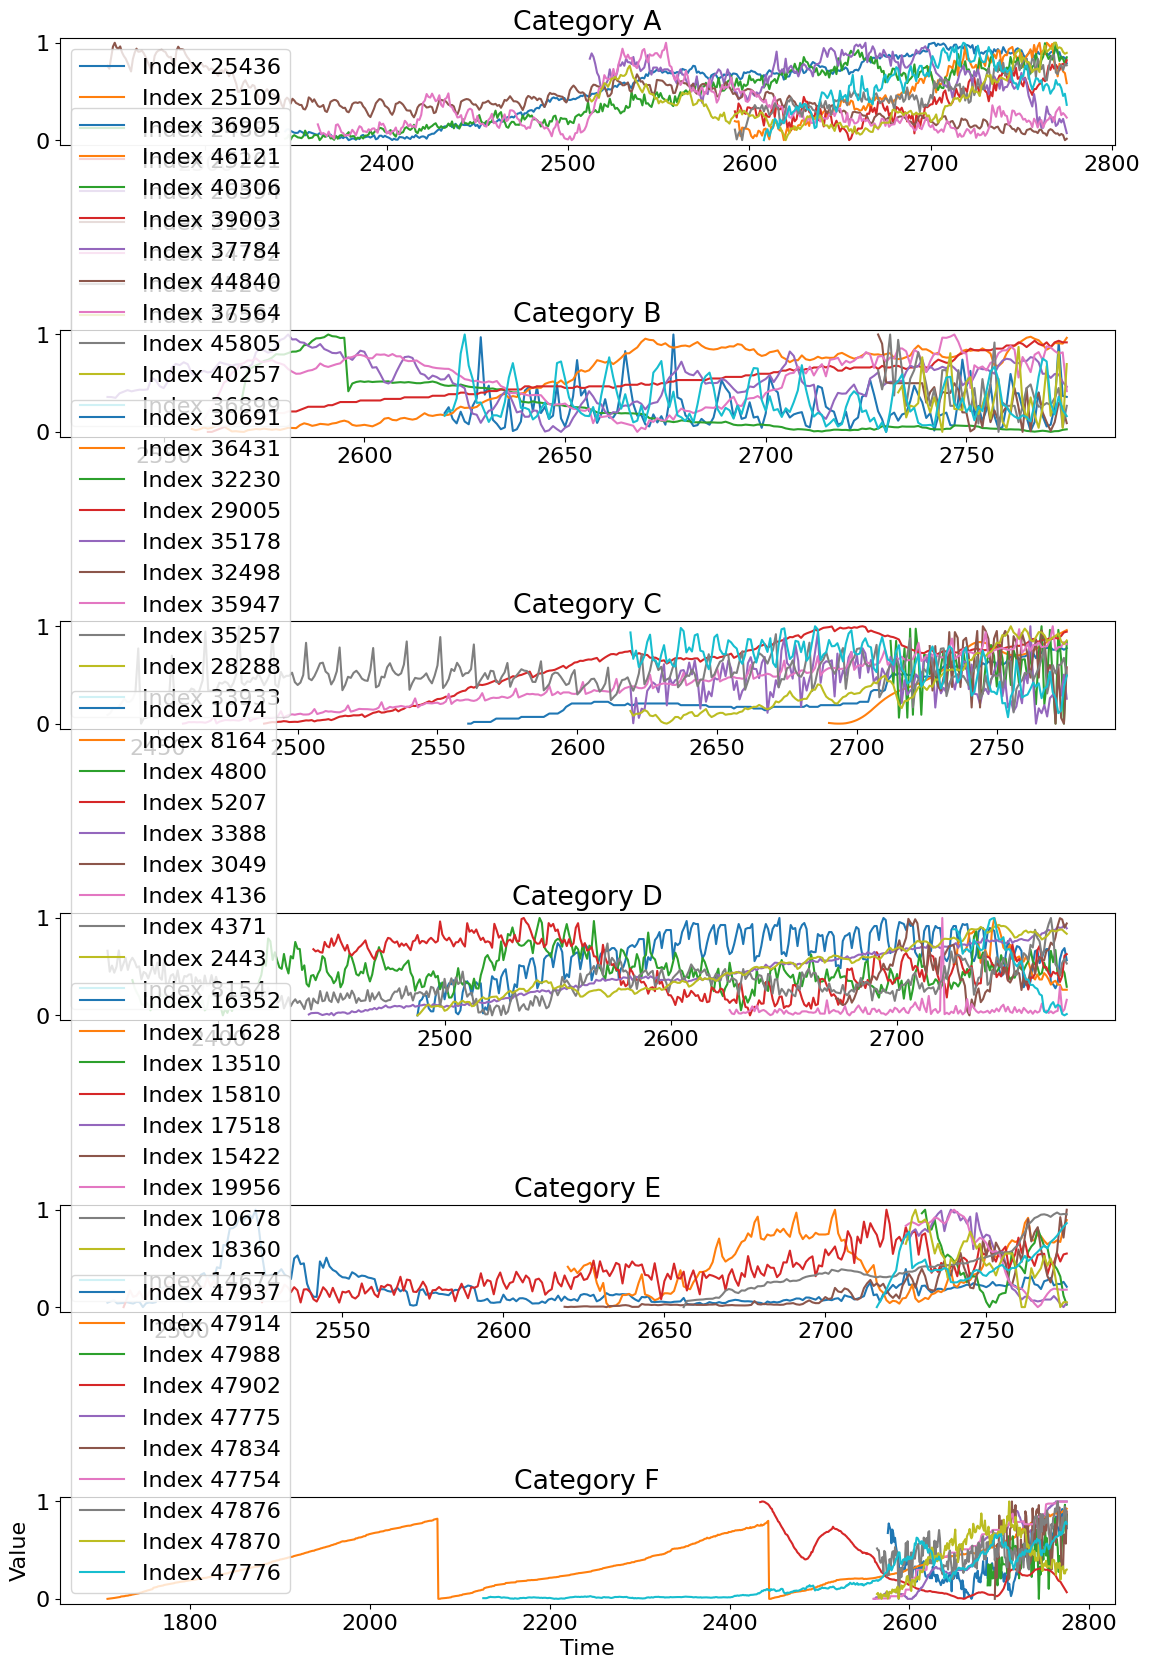

In [26]:
# Plot 10 time series for each category
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12, 18))
for i, category in enumerate(np.unique(categories)):
    # Get the indices of the time series for this category
    indices = np.where(categories == category)[0]
    # Randomly choose 10 indices from this category
    chosen_indices = np.random.choice(indices, 10, replace=False)

    for ts_index in chosen_indices:
        # Find the valid period for this time series
        start, end = valid_periods[ts_index]
        # Plot the time series data for its valid period
        axes[i].plot(range(start, end), training_data[ts_index, start:end], label=f'Index {ts_index}')

    axes[i].set_title(f'Category {category}')
    axes[i].legend()

plt.xlabel('Time')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

In [27]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
reshaped_categories = categories.reshape(-1, 1)
onehot_categories = encoder.fit_transform(reshaped_categories)

onehot_categories

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [28]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
reshaped_categories = categories.reshape(-1, 1)
onehot_categories = encoder.fit_transform(reshaped_categories)

onehot_categories

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [29]:
from sklearn.model_selection import train_test_split

# Split the indices of the time series into training and validation sets
train_indices, val_indices = train_test_split(np.arange(len(training_data_df)), test_size=0.2, random_state=42, stratify=categories)

# Use these indices to create training and validation sets
train_set = training_data_df.iloc[train_indices]
valid_periods_train = valid_periods[train_indices]
onehot_categories_train = onehot_categories[train_indices]

val_set = training_data_df.iloc[val_indices]
valid_periods_val = valid_periods[val_indices]
onehot_categories_val = onehot_categories[val_indices]

train_set.shape, valid_periods_train.shape, onehot_categories_train.shape, val_set.shape, valid_periods_val.shape, onehot_categories_val.shape


((38400, 2776), (38400, 2), (38400, 6), (9600, 2776), (9600, 2), (9600, 6))

In [30]:
def calculate_padding_length(sq, w, t, s):
    cycle = w + t
    if sq <= cycle: return cycle - sq
    else:
        m = (sq - cycle) % s
        if m == 0: return m
        else: return s - m
def create_sequences(df, valid_periods, categories, window, telescope, stride=1):

    input_sequences = []
    input_categories = []
    output_sequences = []


    for i in range(len(valid_periods)):
        start, end = valid_periods[i]
        category = categories[i]

        sequence = df.iloc[i, start:end].values

        padding_length = calculate_padding_length(len(sequence), window, telescope, stride)
        sequence = np.pad(sequence, (padding_length, 0), mode='constant', constant_values=0)

        for j in range(0, len(sequence) - window - telescope + 1, stride):
            input_seq = sequence[j:(j + window)]
            output_seq = sequence[(j + window):(j + window + telescope)]

            input_sequences.append(input_seq)
            input_categories.append(category)
            output_sequences.append(output_seq)

    return np.array(input_sequences), np.array(input_categories), np.array(output_sequences)
window = 100
telescope = 9
stride = 20

In [31]:
X_train, X_train_category, y_train = create_sequences(train_set, valid_periods_train, onehot_categories_train, window, telescope, stride)
X_val, X_val_category, y_val = create_sequences(val_set, valid_periods_val, onehot_categories_val, window, telescope, stride)
X_train.shape, X_train_category.shape, y_train.shape, X_val.shape, X_val_category.shape, y_val.shape


((251638, 100), (251638, 6), (251638, 9), (63460, 100), (63460, 6), (63460, 9))

In [32]:
input_shape = (window, 1)
category_shape = (6, )
output_shape = (telescope, 1)
batch_size = 64
epochs = 200

In [33]:
import tensorflow.keras.layers as tfkl
import tensorflow as tf

def build_CONV_LSTM_model_with_categories(input_shape, category_shape, output_shape):

    # Time series input
    time_series_input = tfkl.Input(shape=input_shape, name='time_series_input')
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True), name='bidirectional_lstm')(time_series_input)
    x = tfkl.Dropout(0.2)(x)  # Adding Dropout after LSTM layer
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = tfkl.Dropout(0.2)(x)  # Adding Dropout after Conv1D layer

    # Category input
    category_input = tfkl.Input(shape=category_shape, name='category_input')
    category_processed = tfkl.Dense(20, activation='relu')(category_input)

    # Combine the processed inputs
    combined = tfkl.Concatenate()([x, tfkl.RepeatVector(input_shape[0])(category_processed)])

    # Continue with convolutional layers
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu')(combined)
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same')(x)
    crop_size = output_layer.shape[1] - output_shape[0]
    output_layer = tfkl.Cropping1D((0, crop_size))(output_layer)

    # Construct the model
    model = tf.keras.Model(inputs=[time_series_input, category_input], outputs=output_layer, name='CONV_LSTM_with_Categories')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model


In [34]:
model = build_CONV_LSTM_model_with_categories(input_shape, category_shape, output_shape)

In [35]:
model.summary()

from tensorflow import keras as tfk
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=15,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    patience=10,
    factor=0.1,
    min_lr=1e-5
)

history = model.fit(
    x = [X_train, X_train_category],
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = ([X_val, X_val_category], y_val),
    callbacks = [
        early_stopping,
        reduce_lr
    ]
).history

Model: "CONV_LSTM_with_Categories"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 time_series_input (InputLa  [(None, 100, 1)]             0         []                            
 yer)                                                                                             
                                                                                                  
 bidirectional_lstm (Bidire  (None, 100, 128)             33792     ['time_series_input[0][0]']   
 ctional)                                                                                         
                                                                                                  
 dropout (Dropout)           (None, 100, 128)             0         ['bidirectional_lstm[0][0]']  
                                                                          

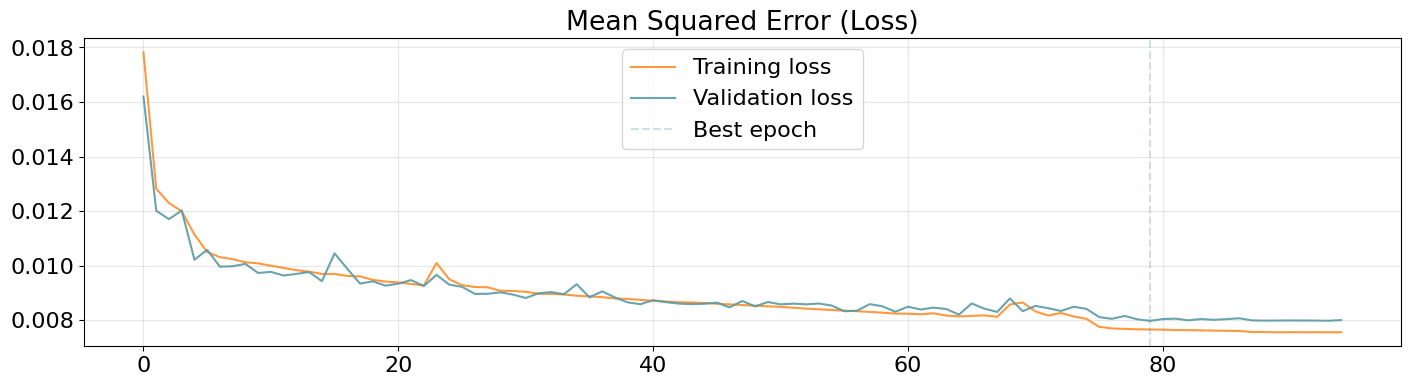

In [36]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()


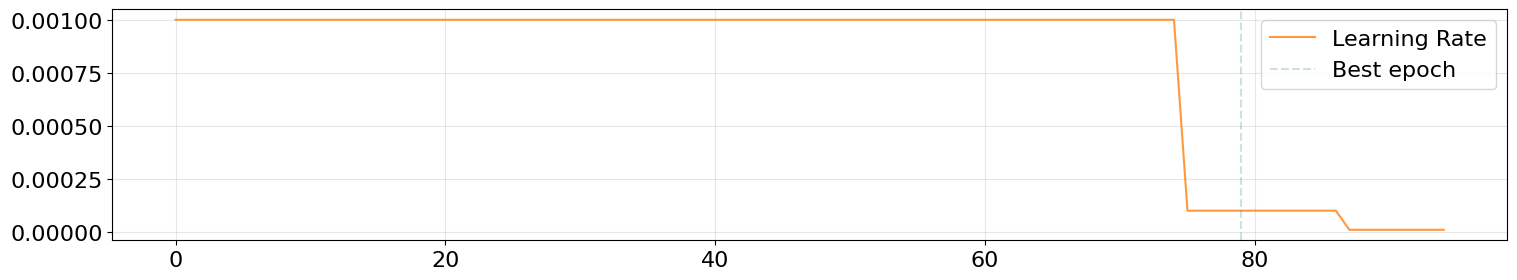

1984/1984 [==============================] - 11s 5ms/step
	zip warning: name not matched: /kaggle/working/conv_lstm_tp9_ws100

zip error: Nothing to do! (try: zip -r conv_lstm_tp9_ws100.zip . -i /kaggle/working/conv_lstm_tp9_ws100)


In [37]:

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()
preds = model.predict([X_val, X_val_category])
preds.shape
model.save('conv_lstm_tp9_ws100')
!zip -r conv_lstm_tp9_ws100.zip /kaggle/working/conv_lstm_tp9_ws100